In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as im
import os 
import pandas as pd
import cv2 as cv
import random
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Data Loading

In [2]:
folder = [
    "dataset/busuk/",
    "dataset/segar/",
    "dataset/setengah segar/"
]
data = []
labels = []
fileName = []
for i in folder:
    label = i.split('/')[-2].lower().replace(" ", "_")
    dataset = os.listdir(i)
    for file in dataset:
        image_path = os.path.join(i, file)
        nama = os.path.splitext(file)[0]
        temp = cv.imread(image_path)
        if temp is None:
            print(f"Error: Tidak dapat memuat gambar di {image_path}")
            continue
        data.append(temp)
        labels.append(label)
        fileName.append(nama)

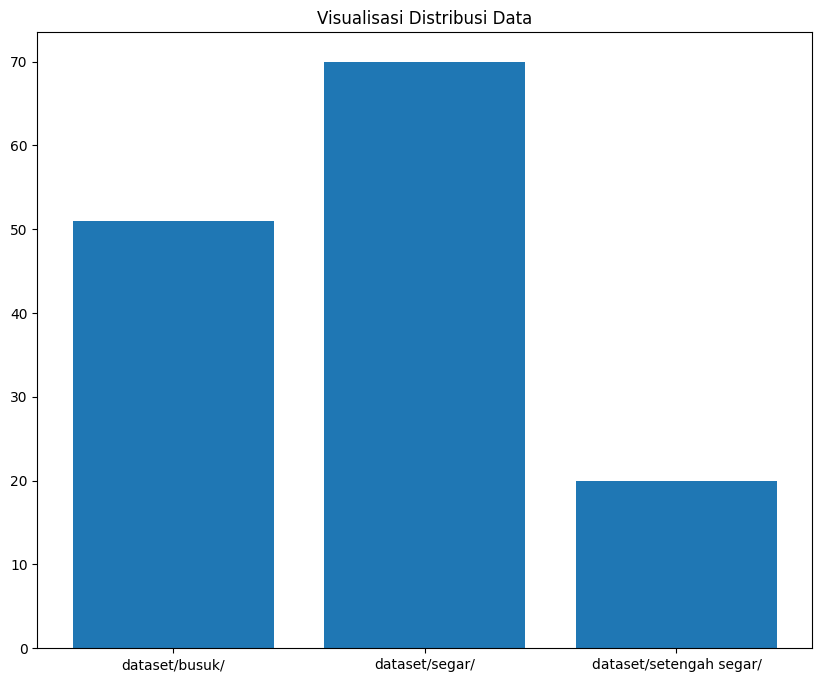

In [3]:
count_data = {}
for i in folder:
    count_data[i] = len(os.listdir(i))

plt.figure(figsize=(10, 8))
plt.bar(count_data.keys(), count_data.values())
plt.title('Visualisasi Distribusi Data')
plt.show()

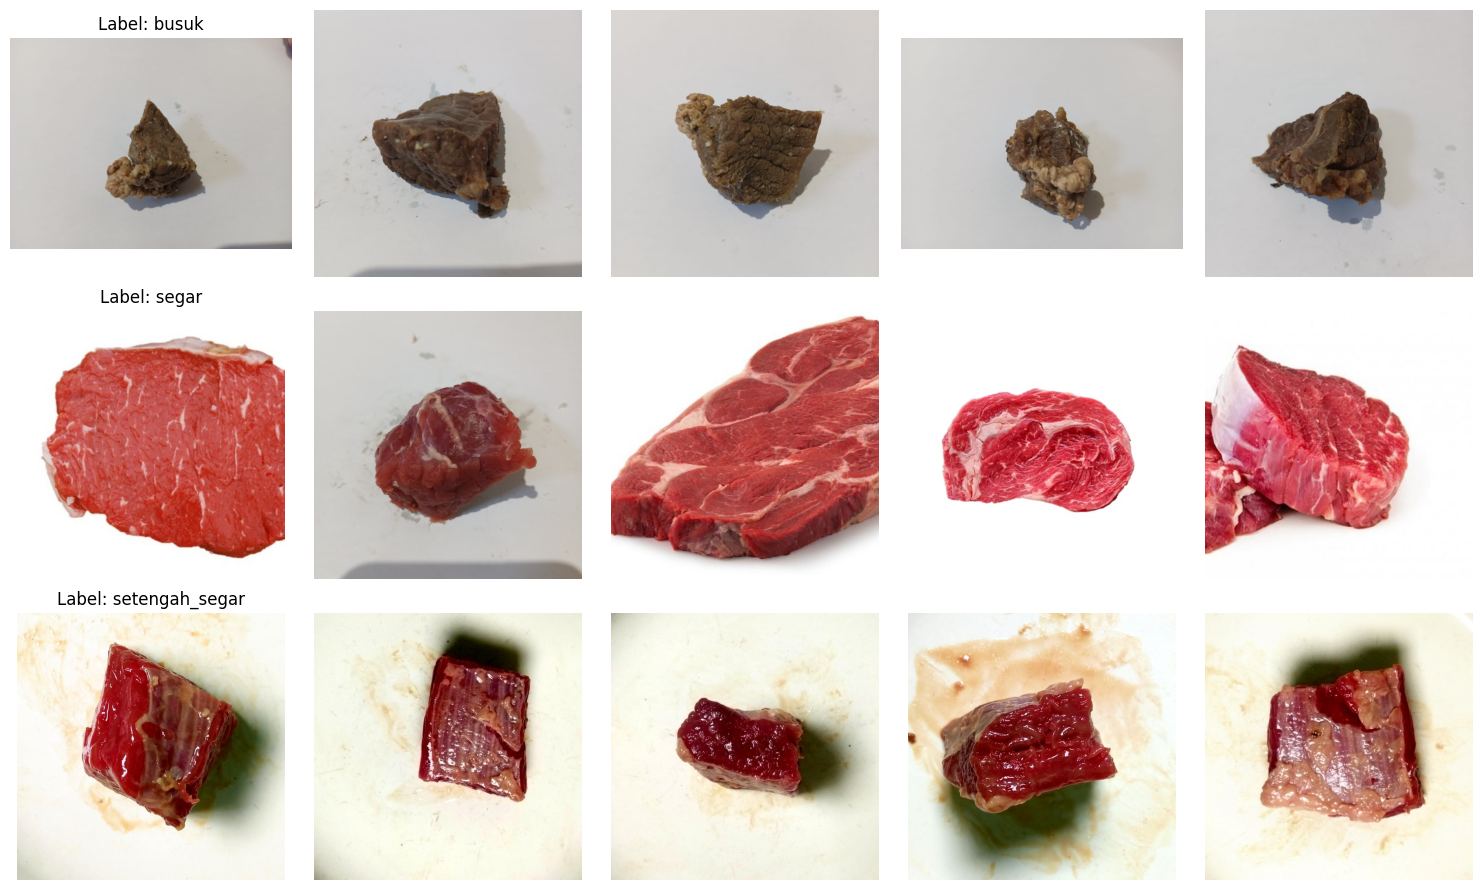

In [4]:
def plot_samples(data, label, num_samples=5):
    unique_labels = np.unique(label)
    fig, axes = plt.subplots(len(unique_labels), num_samples, figsize=(num_samples*3, len(unique_labels)*3))
    for i, j in enumerate(unique_labels):
        indices = [idx for idx, l in enumerate(label) if l == j]
        sample_indices = random.sample(indices, num_samples)
        for k, sample_idx in enumerate(sample_indices):
            if data[sample_idx].ndim == 2: 
                axes[i, k].imshow(data[sample_idx], cmap='gray')
            elif data[sample_idx].shape[2] == 3:
                image = data[sample_idx][:, :, ::-1]
                axes[i, k].imshow(image)
            axes[i, k].axis('off')
            if k == 0:
                axes[i, k].set_title(f'Label: {j}')

    plt.tight_layout()
    plt.show()

plot_samples(data, labels)

# Data Preparation

In [5]:
data = []
labels = []
fileName = []
for i in folder:
    label = i.split('/')[-2].lower().replace(" ", "_")
    dataset = os.listdir(i)
    for file in dataset:
        image_path = os.path.join(i, file)
        nama = os.path.splitext(file)[0]
        temp = cv.imread(image_path)
        if temp is None:
            print(f"Error: Tidak dapat memuat gambar di {image_path}")
            continue
        grayimage = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)
        data.append(grayimage)
        labels.append(label)
        fileName.append(nama)

## Augmentation Image

In [6]:
def getSize(image):
    height, width = image.shape
    return height, width

def rotate90(image, rotation_degree=90):
    height, width = getSize(image)
    rotation_image = np.zeros((height, width), dtype=np.uint8)
    angle = np.deg2rad(rotation_degree)
    center_x, center_y = height // 2, width // 2
    for i in range(height):
        for j in range(width):
            X = int((i - center_x) * np.cos(angle) - (j - center_y) * np.sin(angle) + center_x)
            Y = int((i - center_x) * np.sin(angle) + (j - center_y) * np.cos(angle) + center_y)
            if 0 <= X < height and 0 <= Y < width:
                rotation_image[i][j] = image[X][Y]
    return rotation_image

def rotate270(image, rotation_degree=270):
    height, width = getSize(image)
    rotation_image = np.zeros((height, width), dtype=np.uint8)
    angle = np.deg2rad(rotation_degree)
    center_x, center_y = height // 2, width // 2
    for i in range(height):
        for j in range(width):
            X = int((i - center_x) * np.cos(angle) - (j - center_y) * np.sin(angle) + center_x)
            Y = int((i - center_x) * np.sin(angle) + (j - center_y) * np.cos(angle) + center_y)
            if 0 <= X < height and 0 <= Y < width:
                rotation_image[i][j] = image[X][Y]
    return rotation_image

def mirrorY(image):
    height, width = getSize(image)
    sy = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            y = width - j - 1
            sy[i][j] = image[i][y]
    return sy

def mirrorX(image):
    height, width = getSize(image)
    sx = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            x = height - i - 1
            sx[i][j] = image[x][j]
    return sx

def dilate(image, scale=5):
    height, width = getSize(image)
    dilated_height = height * scale
    dilated_width = width * scale
    dilated_image = np.zeros((dilated_height, dilated_width), dtype=np.uint8)
    for i in range(dilated_height):
        for j in range(dilated_width):
            x = i // scale
            y = j // scale
            dilated_image[i][j] = image[x][y]
    return dilated_image

In [7]:
def augmented_image(image):
    rotated90 = cv.rotate(image, cv.ROTATE_90_CLOCKWISE)
    rotated270 = cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)
    mirrorX_image = cv.flip(image, 0)
    mirrorY_image = cv.flip(image, 1)
    kernel = np.ones((5, 5), np.uint8)
    dilatedImage = cv.dilate(image, kernel, iterations=1)
    
    return rotated90, rotated270, mirrorX_image, mirrorY_image, dilatedImage

In [8]:
augmented_path = 'dataset/augmented/'
kategori = ['busuk', 'segar', 'setengah_segar']

if not os.path.exists(augmented_path):
    os.makedirs(augmented_path)

for i in kategori:
    kategori_path = os.path.join(augmented_path, i)
    if not os.path.exists(kategori_path):
        os.makedirs(kategori_path)

In [9]:
augmented_data = []
augmented_labels = []
augmented_file_names = []

for i, image in enumerate(data):
    label = labels[i]
    name = fileName[i]
    roatated90, rotated270, mirrorX_image, mirrorY_image, dilatedImage = augmented_image(image)

    images = [roatated90, rotated270, mirrorX_image, mirrorY_image, dilatedImage]
    for j, img in enumerate(images):
        aug_name = f"{name}_aug{j}.jpg"
        save_path = os.path.join(augmented_path, label, aug_name)
        cv.imwrite(save_path, img)
        augmented_data.append(img)
        augmented_labels.append(label)
        augmented_file_names.append(aug_name)

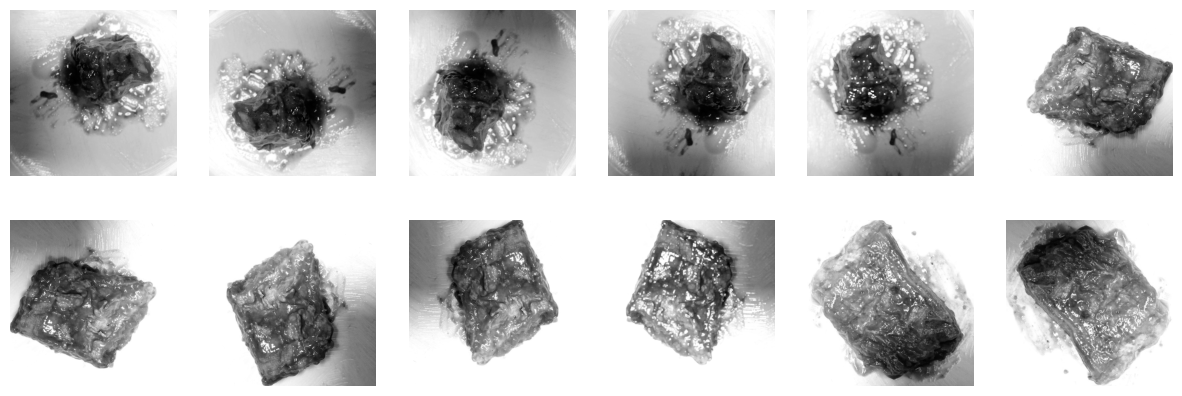

In [10]:
plt.figure(figsize=(15, 5))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.imshow(augmented_data[i], cmap='gray')
    plt.axis('off')
plt.show()

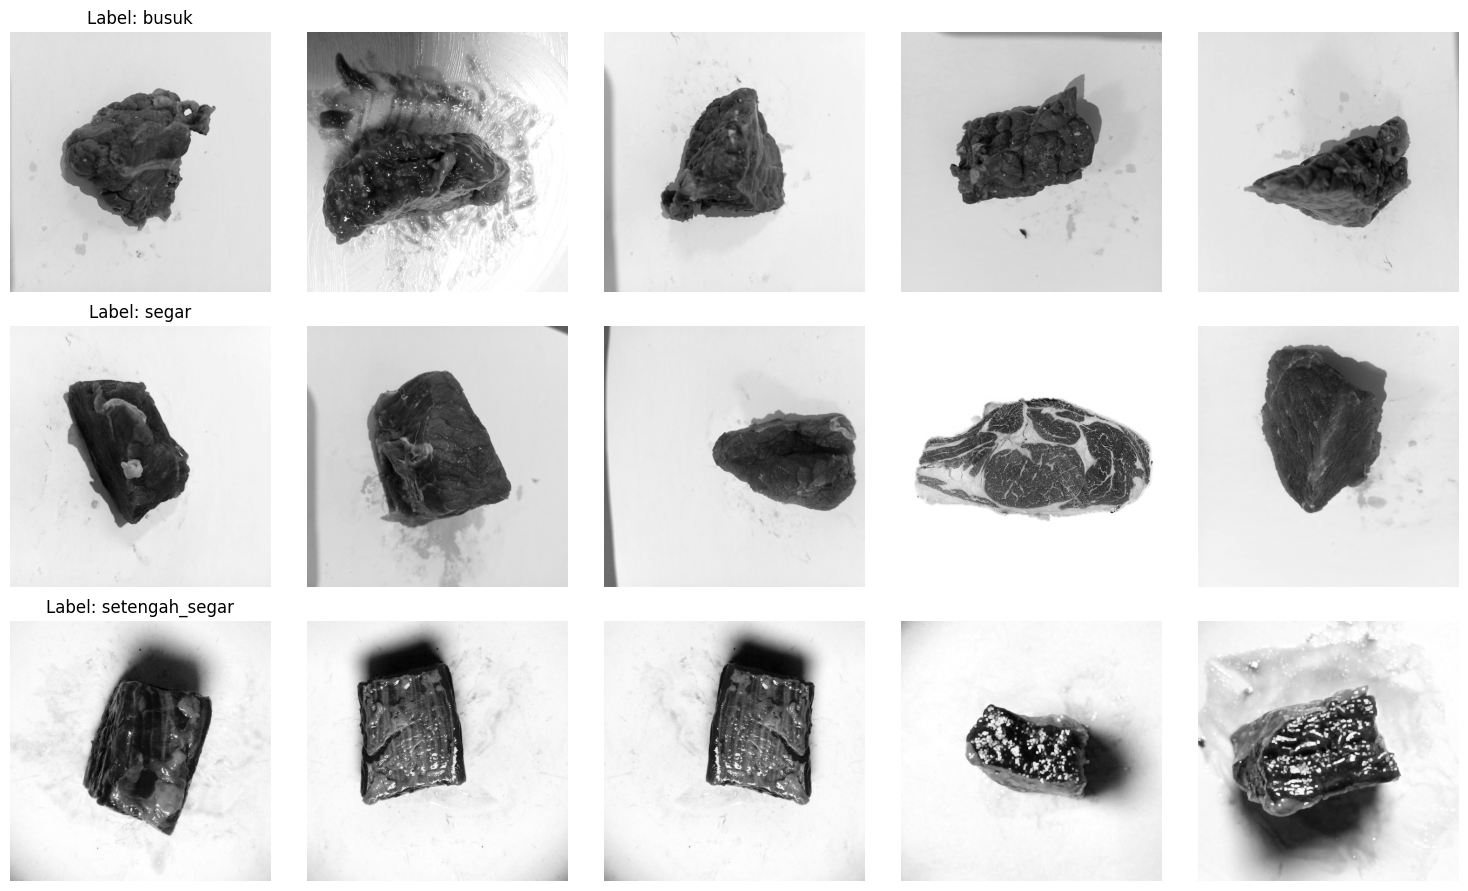

In [16]:
def plot_samples(data, label, num_samples=5):
    unique_labels = np.unique(label)
    fig, axes = plt.subplots(len(unique_labels), num_samples, figsize=(num_samples*3, len(unique_labels)*3))
    for i, j in enumerate(unique_labels):
        indices = [idx for idx, l in enumerate(label) if l == j]
        sample_indices = random.sample(indices, num_samples)
        for k, sample_idx in enumerate(sample_indices):
            if data[sample_idx].ndim == 2: 
                axes[i, k].imshow(data[sample_idx], cmap='gray')
            elif data[sample_idx].shape[2] == 3:
                image = data[sample_idx][:, :, ::-1]
                axes[i, k].imshow(image)
            axes[i, k].axis('off')
            if k == 0:
                axes[i, k].set_title(f'Label: {j}')

    plt.tight_layout()
    plt.show()

plot_samples(augmented_data, augmented_labels)

## Preprocessing Data

In [11]:
def preprocess(image):
    resized_image = cv.resize(image,(500,500))
    equalized_image = cv.equalizeHist(resized_image).astype(np.uint8)
    hapus_noise = cv.GaussianBlur(equalized_image,(5, 5), 0)
    deteksi_tepi = cv.Canny(hapus_noise, 100, 200)
    _, image_biner = cv.threshold(deteksi_tepi, 0, 255, cv.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    closing = cv.morphologyEx(image_biner, cv.MORPH_CLOSE, kernel)
    
    return closing

In [12]:
preprocessed_path = 'dataset/preprocess/'
kategori = ['busuk', 'segar', 'setengah_segar']

if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)

for i in kategori:
    kategori_path = os.path.join(preprocessed_path, i)
    if not os.path.exists(kategori_path):
        os.makedirs(kategori_path)

In [13]:
preprocess_data = []
preprocess_labels = []
preprocess_file_names = []

counter = {'busuk': 1, 'segar': 1, 'setengah_segar': 1}

for i, image in enumerate(augmented_data):
    label = augmented_labels[i]
    name = augmented_file_names[i]
    prepro_image = preprocess(image)
    
    if label not in counter:
        print(f"Label {label} tidak ditemukan dalam counter dictionary.")
        continue

    images = [prepro_image]
    for j, img in enumerate(images):
        label_folder = label.lower()
        save_name = f"{label_folder}_{counter[label_folder]}.jpg"
        save_path = os.path.join(preprocessed_path, label_folder, save_name)
        cv.imwrite(save_path, img)
        preprocess_data.append(img)
        preprocess_labels.append(label)
        preprocess_file_names.append(save_name)
        counter[label_folder] += 1

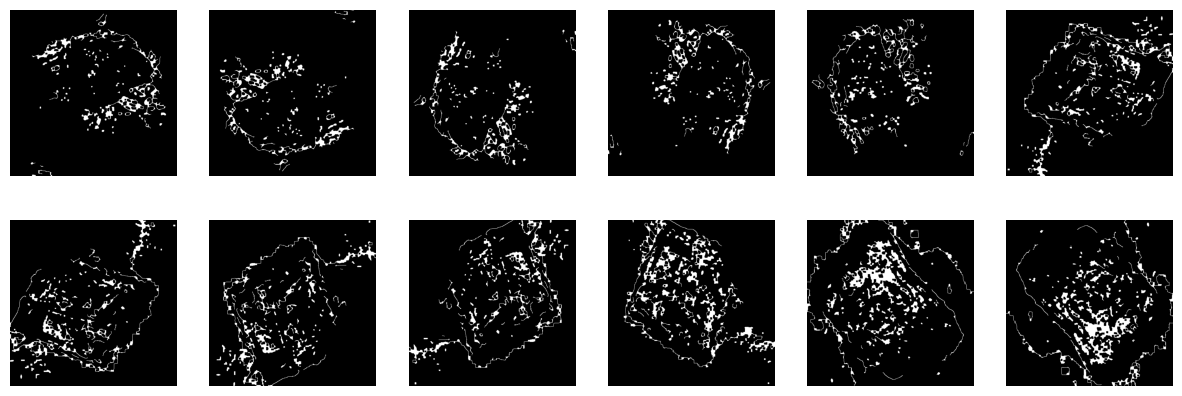

In [14]:
plt.figure(figsize=(15, 5))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.imshow(preprocess_data[i], cmap='gray')
    plt.axis('off')
plt.show()

In [15]:
jenis = {
    'busuk' :0,
    'segar' :1,
    'setengah_segar' :2
}

In [16]:
def extract_glcm_features(images, labels, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    angle_labels = ['0', '45', '90', '135']
    df_data = pd.DataFrame()
    for i, image in enumerate(images):
        image = image.astype(int)
        glcm = graycomatrix(image, distances, angles, levels, symmetric, normed)
        for feature in features:
            for angle, angle_label in zip(angles, angle_labels):
                feat_a = graycoprops(glcm, feature)[0, int(angle*4/np.pi)]
                df_data.loc[i, f'{feature}_{angle_label}'] = feat_a
        for angle, angle_label in zip(angles, angle_labels):
            asm = np.sum(glcm[:, :, 0, int(angle*4/np.pi)]**2)
            entropy = -np.sum(glcm[:, :, 0, int(angle*4/np.pi)]*np.log2(glcm[:, :, 0, int(angle*4/np.pi)] + np.finfo(float).eps))
            df_data.loc[i, f'asm_{angle_label}'] = asm
            df_data.loc[i, f'entropy_{angle_label}'] = entropy
        df_data.loc[i, 'label'] = jenis[labels[i]]
    return df_data

# Evaluasi

In [17]:
folder_baru = [
    "dataset/preprocess/busuk/",
    "dataset/preprocess/segar/",
    "dataset/preprocess/setengah_segar/"
]
data_baru = []
labels_baru = []
fileName_baru = []
for i in folder_baru:
    label = i.split('/')[-2].lower().replace(" ", "_")
    dataset = os.listdir(i)
    for file in dataset:
        image_path = os.path.join(i, file)
        nama = os.path.splitext(file)[0]
        temp = cv.imread(image_path)
        if temp is None:
            print(f"Error: Tidak dapat memuat gambar di {image_path}")
            continue
        grayimage = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)
        data_baru.append(grayimage)
        labels_baru.append(label)
        fileName_baru.append(nama)

## GLCM Before Augmentation & Preprocessing

In [18]:
df_glcm = extract_glcm_features(data, labels=labels)

In [19]:
df_glcm

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,label
0,280.509868,299.639203,253.704662,311.036746,8.662059,9.008351,8.091659,9.200747,0.246292,0.223967,...,0.964685,0.000462,12.934500,0.000406,13.005976,0.000464,12.844918,0.000443,13.014965,0.0
1,445.626076,473.745114,411.986987,472.406507,9.654942,10.177193,9.330239,10.263869,0.437060,0.424963,...,0.952824,0.113902,9.817991,0.111844,9.904494,0.113652,9.808939,0.111647,9.916603,0.0
2,694.747084,789.948825,712.643256,700.638580,13.702776,14.951861,13.847735,13.818073,0.323298,0.310538,...,0.936735,0.054995,11.474744,0.052513,11.609896,0.053643,11.501551,0.052914,11.527343,0.0
3,711.484174,700.136626,695.223930,789.792976,13.825977,13.810879,13.702131,14.947216,0.320790,0.319308,...,0.928686,0.053721,11.497709,0.053029,11.524477,0.055102,11.472788,0.052632,11.607236,0.0
4,459.035925,514.987840,462.088013,513.951740,10.791678,11.701554,11.113258,11.820833,0.323285,0.313647,...,0.951649,0.041428,11.218604,0.039912,11.338060,0.041511,11.262799,0.039916,11.348689,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,368.957193,401.123006,302.421937,387.587792,8.951657,9.571923,7.807760,9.290852,0.251586,0.233158,...,0.968900,0.001473,12.042305,0.001339,12.123642,0.001560,11.887540,0.001346,12.100802,2.0
137,346.683926,397.940445,275.908976,277.078955,7.131424,7.713010,6.275783,6.349109,0.406745,0.388630,...,0.977449,0.006946,10.103872,0.006090,10.218408,0.007289,10.005477,0.006078,10.125327,2.0
138,182.524392,264.909764,303.358069,306.936581,5.987457,7.088695,7.271430,7.467144,0.289312,0.266283,...,0.976114,0.002599,10.674160,0.002410,10.818219,0.002612,10.774388,0.002463,10.834799,2.0
139,391.541795,406.363415,258.664007,371.844040,7.385501,7.599882,5.847022,7.508360,0.443627,0.421944,...,0.969199,0.015124,9.884938,0.013338,9.980196,0.015807,9.722600,0.013365,9.983144,2.0


In [20]:
df_glcm.to_csv('glcm_features_before.csv', index=False)
df_glcm = pd.read_csv('glcm_features_before.csv')

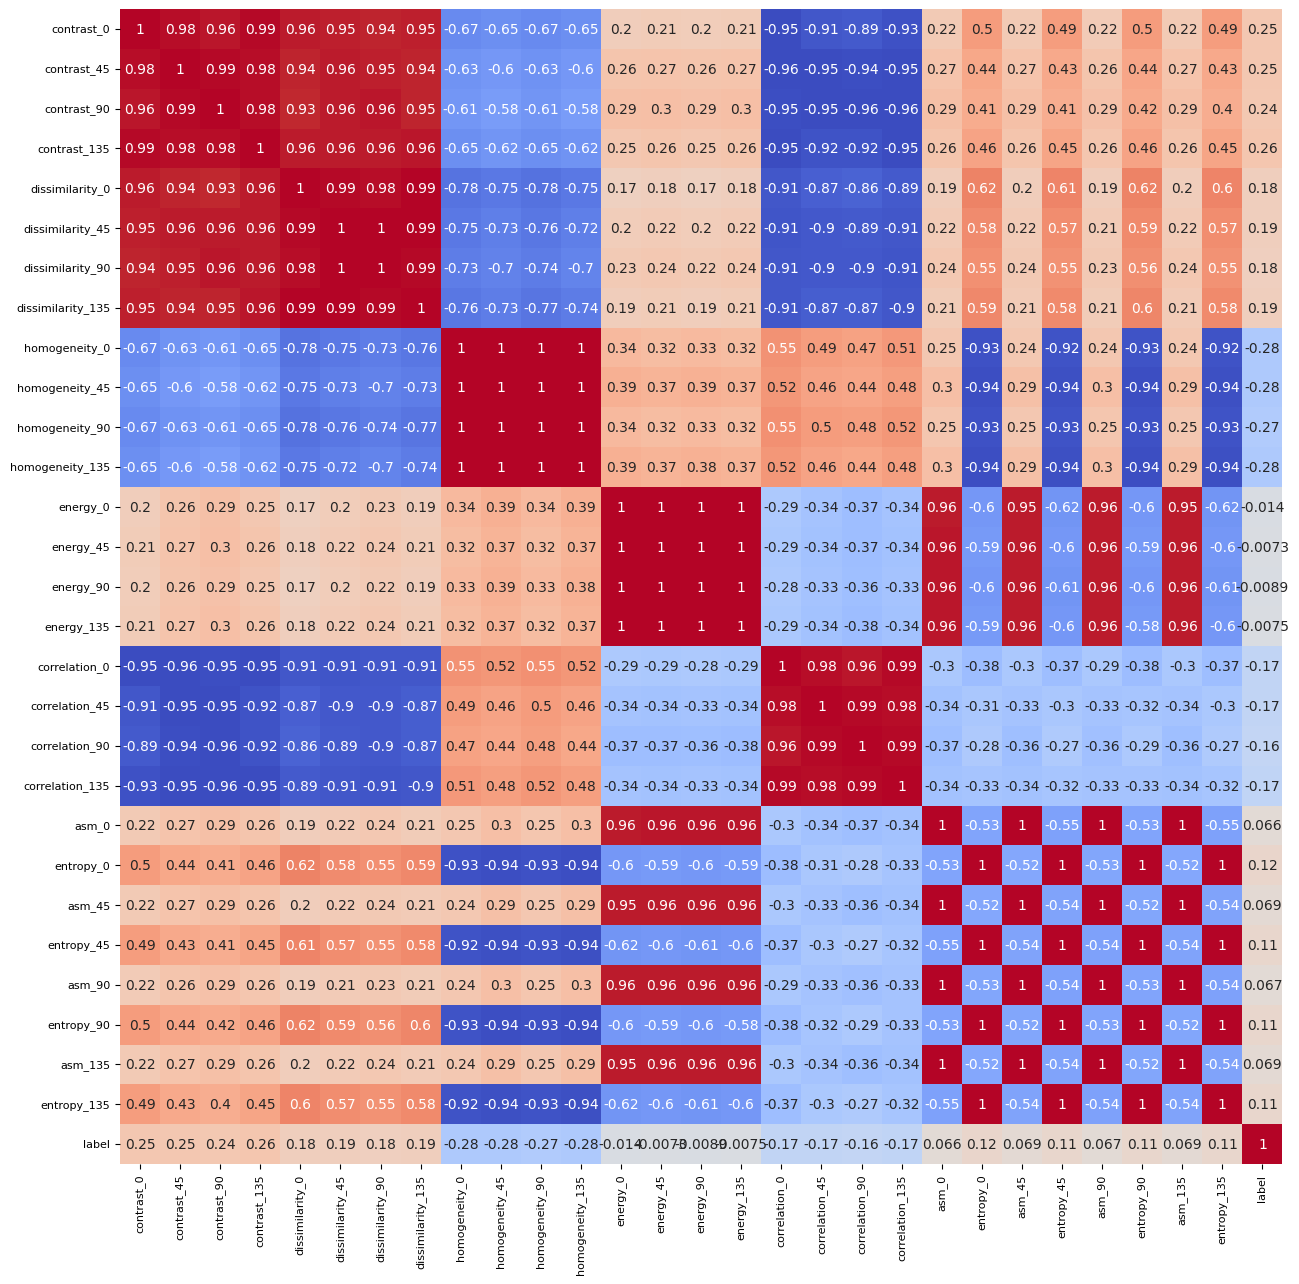

In [30]:
corr_glcm = df_glcm.corr()  
plt.figure(figsize=(15,15))
sns.heatmap(corr_glcm, annot=True, cmap='coolwarm', cbar=False)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.show()

In [21]:
x, y = df_glcm.drop('label', axis=1), df_glcm['label']
pca = PCA(n_components=25)
x_pca = pca.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((112, 25), (29, 25), (112,), (29,))

In [22]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [23]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6896551724137931


In [24]:
svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.7931034482758621


In [25]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8275862068965517


In [26]:
model_dict = {
    'KNN': knn,
    'SVM': svm,
    'RF': rfc
}
df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())


In [27]:
for model_name, model in model_dict.items():
    y_pred = model.predict(x_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test, y_pred, average='weighted')
    
df_eval

,Accuracy,Precision,Recall,F1 Score
KNN,0.689655,0.727273,0.689655,0.687028
SVM,0.793103,0.799808,0.793103,0.791655
RF,0.827586,0.840568,0.827586,0.821427


## GLCM After Augmentation & Before Preprocessing

In [28]:
df_glcm_aug = extract_glcm_features(augmented_data, labels= augmented_labels)

df_glcm_aug

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,label
0,253.704662,311.036746,280.509868,299.639203,8.091659,9.200747,8.662059,9.008351,0.246413,0.230134,...,0.965979,0.000464,12.844918,0.000443,13.014965,0.000462,12.934500,0.000406,13.005976,0.0
1,253.704662,311.036746,280.509868,299.639203,8.091659,9.200747,8.662059,9.008351,0.246413,0.230134,...,0.965979,0.000464,12.844918,0.000443,13.014965,0.000462,12.934500,0.000406,13.005976,0.0
2,280.509868,311.036746,253.704662,299.639203,8.662059,9.200747,8.091659,9.008351,0.246292,0.230134,...,0.965979,0.000462,12.934500,0.000443,13.014965,0.000464,12.844918,0.000406,13.005976,0.0
3,280.509868,311.036746,253.704662,299.639203,8.662059,9.200747,8.091659,9.008351,0.246292,0.230134,...,0.965979,0.000462,12.934500,0.000443,13.014965,0.000464,12.844918,0.000406,13.005976,0.0
4,356.789441,413.615555,361.879066,429.204662,8.746441,9.533594,8.395585,9.689447,0.288729,0.260663,...,0.947428,0.001286,12.602847,0.001148,12.734778,0.001298,12.519870,0.001274,12.735074,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,288.347096,393.634244,382.061251,367.639636,6.429847,7.851017,7.533889,7.498582,0.357074,0.320576,...,0.972348,0.005731,10.658095,0.004820,10.900488,0.005640,10.768641,0.005044,10.809147,2.0
701,288.347096,393.634244,382.061251,367.639636,6.429847,7.851017,7.533889,7.498582,0.357074,0.320576,...,0.972348,0.005731,10.658095,0.004820,10.900488,0.005640,10.768641,0.005044,10.809147,2.0
702,382.061251,393.634244,288.347096,367.639636,7.533889,7.851017,6.429847,7.498582,0.347284,0.320576,...,0.972348,0.005640,10.768641,0.004820,10.900488,0.005731,10.658095,0.005044,10.809147,2.0
703,382.061251,393.634244,288.347096,367.639636,7.533889,7.851017,6.429847,7.498582,0.347284,0.320576,...,0.972348,0.005640,10.768641,0.004820,10.900488,0.005731,10.658095,0.005044,10.809147,2.0


In [32]:
df_glcm_aug.to_csv('glcm_features_aug.csv', index=False)
df_glcm_aug = pd.read_csv('glcm_features_aug.csv')

In [33]:
x, y = df_glcm_aug.drop('label', axis=1), df_glcm_aug['label']
pca = PCA(n_components=25)
x_pca = pca.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((564, 25), (141, 25), (564,), (141,))

In [34]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [41]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9432624113475178


In [37]:
svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9219858156028369


In [38]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9716312056737588


In [42]:
model_dict = {
    'KNN': knn,
    'SVM': svm,
    'RF': rfc
}
df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())

In [43]:
for model_name, model in model_dict.items():
    y_pred = model.predict(x_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test, y_pred, average='weighted')
    
df_eval

,Accuracy,Precision,Recall,F1 Score
KNN,0.943262,0.946005,0.943262,0.942822
SVM,0.921986,0.92206,0.921986,0.92197
RF,0.971631,0.972176,0.971631,0.971671


## GLCM After Augmentation & Preprocessing

In [44]:
df_glcm_proces = extract_glcm_features(data_baru, labels= labels_baru)

df_glcm_proces

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,label
0,3331.942263,3690.069061,3472.065277,3516.702971,13.251846,14.662412,13.803014,13.981570,0.903937,0.898379,...,0.304190,0.762639,1.205103,0.756189,1.224509,0.761663,1.207525,0.757347,1.220622,0.0
1,6587.580804,6943.008963,6205.243099,6769.061268,26.166396,27.568666,24.664691,26.885255,0.822368,0.816333,...,0.322172,0.589290,2.004293,0.582768,2.023591,0.592211,1.992289,0.582964,2.021726,0.0
2,903.167451,1047.157713,1010.987964,959.771161,3.602949,4.169704,4.026396,3.826906,0.969687,0.967497,...,0.206334,0.921549,0.439054,0.918690,0.448221,0.920631,0.442067,0.918933,0.447192,0.0
3,657.989899,666.529262,605.475180,694.215852,2.624299,2.658953,2.418412,2.767214,0.977927,0.977201,...,0.099525,0.943189,0.326672,0.941808,0.330287,0.943619,0.324812,0.941933,0.329945,0.0
4,660.039006,675.414737,614.631863,702.427094,2.633325,2.694695,2.455273,2.801070,0.977453,0.976826,...,0.098868,0.941529,0.334835,0.940399,0.337787,0.941858,0.333045,0.939426,0.340550,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,3750.336448,4053.769365,3717.705701,4194.614326,14.916699,16.112123,14.787261,16.664900,0.890580,0.885749,...,0.215470,0.736235,1.314706,0.730572,1.329335,0.736975,1.310760,0.729849,1.331656,2.0
701,5034.910921,5721.763597,5473.584844,5499.730900,20.017135,22.721258,21.742380,21.849055,0.857712,0.847522,...,0.315963,0.657889,1.692405,0.647390,1.725445,0.652334,1.711667,0.649537,1.719408,2.0
702,5009.464032,5712.496838,5428.539414,5460.257138,19.917349,22.686110,21.567737,21.695247,0.857733,0.847263,...,0.319474,0.657489,1.695021,0.646152,1.730366,0.650406,1.719738,0.648169,1.724246,2.0
703,5486.546816,5718.303972,5017.446287,5501.980749,21.789152,22.703727,19.944057,21.854432,0.852545,0.848466,...,0.329221,0.652506,1.710100,0.647411,1.723910,0.657498,1.691479,0.648707,1.719357,2.0


In [45]:
df_glcm_proces.to_csv('glcm_features.csv', index=False)
df_glcm_proces = pd.read_csv('glcm_features.csv')

In [47]:
x, y = df_glcm_proces.drop('label', axis=1), df_glcm_proces['label']
pca = PCA(n_components=25)
x_pca = pca.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((564, 25), (141, 25), (564,), (141,))

In [48]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [49]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.7872340425531915


In [50]:
svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8297872340425532


In [51]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8865248226950354


In [52]:
model_dict = {
    'KNN': knn,
    'SVM': svm,
    'RF': rfc
}
df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())

In [53]:
for model_name, model in model_dict.items():
    y_pred = model.predict(x_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test, y_pred, average='weighted')
    
df_eval

,Accuracy,Precision,Recall,F1 Score
KNN,0.787234,0.797957,0.787234,0.789263
SVM,0.829787,0.827564,0.829787,0.827591
RF,0.886525,0.886831,0.886525,0.886471


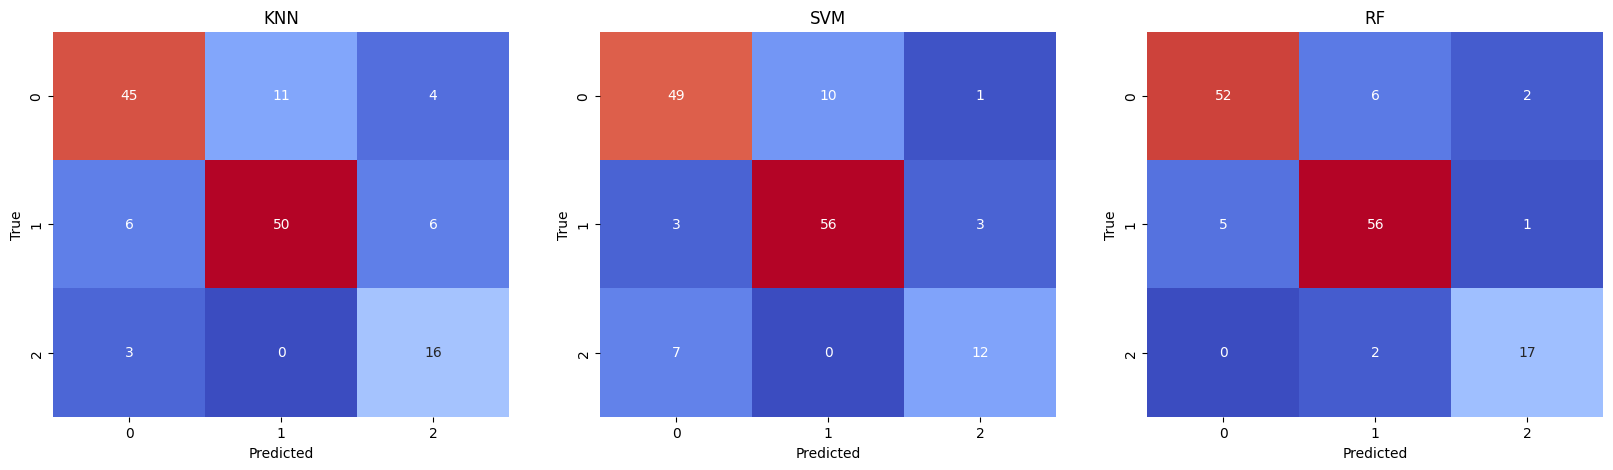

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, model_name in enumerate(model_dict.keys()):
    y_pred = model_dict[model_name].predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(model_name)
plt.show()